In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'GBPUSD'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,wclose,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6087,1.6104,1.5879,1.5927,0.0,1.595925,16.326531,16.326531,16.326531,...,1.61380,1.59660,1.605200,1.59915,141.857175,183.609406,224.795834,47.024049,-580.628944,-558.700648
30,14/2/2000,1.5927,1.5971,1.5860,1.5873,1.0,1.589425,4.166667,4.153355,4.153355,...,1.60375,1.58695,1.595350,1.59155,123.669380,146.514411,172.781294,252.413836,-379.571709,-528.186512
31,15/2/2000,1.5873,1.5976,1.5851,1.5960,1.0,1.593675,43.083004,33.956386,33.850932,...,1.59735,1.58555,1.591450,1.59135,191.458027,144.278393,157.105210,266.956749,-81.647095,-483.338404
32,16/2/2000,1.5960,1.6100,1.5946,1.6072,1.0,1.604750,88.755020,87.351779,68.847352,...,1.60380,1.58985,1.596825,1.60230,-107.547908,37.248993,132.796436,273.808202,136.045358,-474.973133
33,17/2/2000,1.6072,1.6138,1.6027,1.6083,0.0,1.608275,80.836237,80.836237,80.836237,...,1.61190,1.59865,1.605275,1.60825,-68.693550,-67.738396,101.820193,273.911976,330.800262,-430.288438


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,wclose,so_3,so_4,so_5,so_8,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,1.6104,1.6087,1.5879,1.5927,1.595925,16.326531,16.326531,16.326531,27.218935,...,1.61380,1.59660,1.605200,1.59915,141.857175,183.609406,224.795834,47.024049,-580.628944,-558.700648
30,14/2/2000,1.5971,1.5927,1.5860,1.5873,1.589425,4.166667,4.153355,4.153355,11.242604,...,1.60375,1.58695,1.595350,1.59155,123.669380,146.514411,172.781294,252.413836,-379.571709,-528.186512
31,15/2/2000,1.5976,1.5873,1.5851,1.5960,1.593675,43.083004,33.956386,33.850932,36.982249,...,1.59735,1.58555,1.591450,1.59135,191.458027,144.278393,157.105210,266.956749,-81.647095,-483.338404
32,16/2/2000,1.6100,1.5960,1.5946,1.6072,1.604750,88.755020,87.351779,68.847352,68.633540,...,1.60380,1.58985,1.596825,1.60230,-107.547908,37.248993,132.796436,273.808202,136.045358,-474.973133
33,17/2/2000,1.6138,1.6072,1.6027,1.6083,1.608275,80.836237,80.836237,80.836237,72.049689,...,1.61190,1.59865,1.605275,1.60825,-68.693550,-67.738396,101.820193,273.911976,330.800262,-430.288438


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.44281622, 0.44759583, 0.44222977, ..., 0.61738803, 0.28172206,
        0.20939202],
       [0.42816219, 0.42986927, 0.44014894, ..., 0.68964772, 0.37258541,
        0.22458155],
       [0.42871309, 0.42388655, 0.43916329, ..., 0.69476417, 0.50722582,
        0.24690633],
       ...,
       [0.10962979, 0.10658099, 0.12463038, ..., 0.58837191, 0.37092742,
        0.47936984],
       [0.10434112, 0.10569466, 0.11652612, ..., 0.65017329, 0.49102879,
        0.50262451],
       [0.0976201 , 0.09849324, 0.11784032, ..., 0.64788023, 0.5969593 ,
        0.5061798 ]])

In [10]:
input_data.shape

(5183, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.44281622, 0.44759583, 0.44222977, ..., 0.61738803, 0.28172206,
        0.20939202],
       [0.42816219, 0.42986927, 0.44014894, ..., 0.68964772, 0.37258541,
        0.22458155],
       [0.42871309, 0.42388655, 0.43916329, ..., 0.69476417, 0.50722582,
        0.24690633],
       ...,
       [0.10962979, 0.10658099, 0.12463038, ..., 0.58837191, 0.37092742,
        0.47936984],
       [0.10434112, 0.10569466, 0.11652612, ..., 0.65017329, 0.49102879,
        0.50262451],
       [0.0976201 , 0.09849324, 0.11784032, ..., 0.64788023, 0.5969593 ,
        0.5061798 ]])

In [13]:
input_data[[0],1:]

array([[0.44759583, 0.44222977, 0.42986927, 0.43448849, 0.34793734,
        0.3515838 , 0.35583121, 0.41457158, 0.41260087, 0.38039569,
        0.43195315, 0.43195315, 0.41457158, 0.41260087, 0.38039569,
        0.44437551, 0.42939113, 0.38444778, 0.407909  , 0.46295867,
        0.52271439, 0.33917658, 0.44676144, 0.44447556, 0.44459004,
        0.43930315, 0.44478368, 0.61087005, 0.64403346, 0.61738803,
        0.28172206, 0.20939202]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.44759583, 0.44222977, 0.42986927, ..., 0.61738803,
          0.28172206, 0.20939202]],

        [[0.42986927, 0.44014894, 0.42388655, ..., 0.68964772,
          0.37258541, 0.22458155]],

        [[0.42388655, 0.43916329, 0.43352537, ..., 0.69476417,
          0.50722582, 0.24690633]],

        ...,

        [[0.41635276, 0.42788304, 0.41236428, ..., 0.51574587,
          0.45447428, 0.37550568]],

        [[0.41236428, 0.42952579, 0.41856858, ..., 0.59300695,
          0.45093511, 0.37489426]],

        [[0.41856858, 0.43138758, 0.41557722, ..., 0.64002525,
          0.44483384, 0.37407491]]],


       [[[0.42986927, 0.44014894, 0.42388655, ..., 0.68964772,
          0.37258541, 0.22458155]],

        [[0.42388655, 0.43916329, 0.43352537, ..., 0.69476417,
          0.50722582, 0.24690633]],

        [[0.43352537, 0.44956741, 0.44593397, ..., 0.69717463,
          0.60560709, 0.25107045]],

        ...,

        [[0.41236428, 0.42952579, 0.41856858, ..., 0.59300695,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4620, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4620/4620 [==============================] - 10s 2ms/step - loss: 0.0123
Epoch 2/5
4620/4620 [==============================] - 8s 2ms/step - loss: 5.6463e-04
Epoch 3/5
4620/4620 [==============================] - 9s 2ms/step - loss: 4.14

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([1.3586, 1.3582, 1.3562, 1.3555, 1.3744, 1.382 , 1.3806, 1.3942,
       1.3913, 1.3945, 1.3991, 1.4027, 1.4263, 1.4345, 1.4285, 1.4209,
       1.4167, 1.4233, 1.4278, 1.4278, 1.4151, 1.4   , 1.3994, 1.4067,
       1.3987, 1.3876, 1.3924, 1.4017, 1.4104, 1.4145, 1.405 , 1.4025,
       1.4009, 1.3989, 1.4005, 1.407 , 1.3997, 1.3916, 1.3785, 1.3817,
       1.3877, 1.393 , 1.3912, 1.391 , 1.3889, 1.3918, 1.3994, 1.3996,
       1.3989, 1.398 , 1.4088, 1.4067, 1.4151, 1.4219, 1.4172, 1.4245,
       1.4244, 1.42  , 1.4096, 1.406 , 1.4078, 1.4089, 1.4097, 1.4097,
       1.4105, 1.4164, 1.4188, 1.4223, 1.4247, 1.4297, 1.4344, 1.4377,
       1.4315, 1.4246, 1.4091, 1.4031, 1.3987, 1.3997, 1.3998, 1.3935,
       1.3804, 1.3773, 1.3666, 1.363 , 1.3586, 1.3575, 1.3593, 1.3607,
       1.3618, 1.3596, 1.3608, 1.3572, 1.3521, 1.3569, 1.3528, 1.3493,
       1.3492, 1.3443, 1.3422, 1.3389, 1.3341, 1.3325, 1.3307, 1.3348,
       1.3362, 1.3399, 1.3409, 1.3443, 1.3472, 1.3439, 1.3441, 1.3425,
      

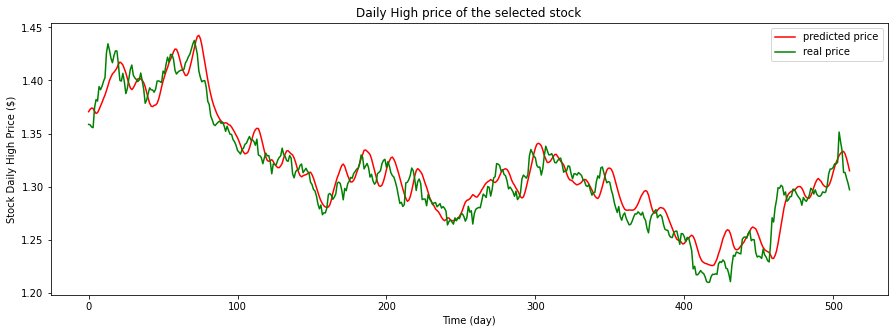

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,1.3586,1.370606,NaN,NaN
1,1.3582,1.372762,1.370606,0.002156
2,1.3562,1.374041,1.372762,0.001279
3,1.3555,1.373608,1.374041,-0.000433
4,1.3744,1.371003,1.373608,-0.002605
...,...,...,...,...
507,1.3134,1.333191,1.332621,0.000570
508,1.3133,1.330887,1.333191,-0.002304
509,1.3080,1.326581,1.330887,-0.004306
510,1.3032,1.321064,1.326581,-0.005517


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.3586,1.370606,NaN,NaN,NaN,1.356125,NaN
1,1.3582,1.372762,1.370606,0.002156,0.317501,1.354200,-0.001419
2,1.3562,1.374041,1.372762,0.001279,0.188584,1.351450,-0.002031
3,1.3555,1.373608,1.374041,-0.000433,-0.063835,1.352225,0.000573
4,1.3744,1.371003,1.373608,-0.002605,-0.379038,1.368475,0.012017
5,1.3820,1.368932,1.371003,-0.002071,-0.299719,1.378200,0.007106
6,1.3806,1.369712,1.368932,0.000779,0.112922,1.378300,0.000073
7,1.3942,1.372465,1.369712,0.002754,0.395004,1.384025,0.004154
8,1.3913,1.376034,1.372465,0.003569,0.513011,1.387650,0.002619
9,1.3945,1.379221,1.376034,0.003186,0.457008,1.388150,0.000360


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

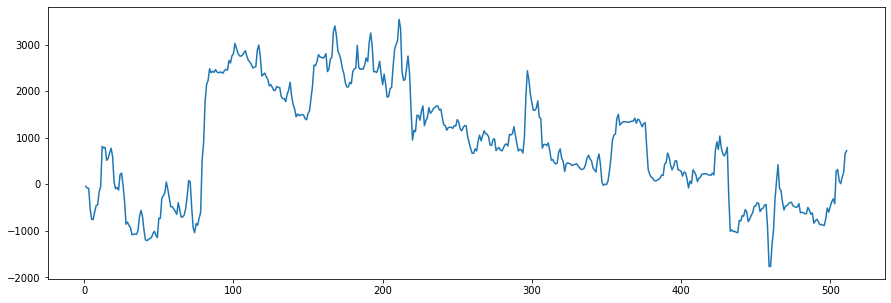

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

0.10382240243062495

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.0441767068273093

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 2027.7016357490693 , from day 12 , to day 42
